<a href="https://colab.research.google.com/github/sergiopaniego/BehaviorStudio-experiments/blob/main/BS_lenet_classification_network_extreme_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# When using Colab, check the GPU that is assigned and reload the runtime if its memory is low
!nvidia-smi

Tue Mar 16 13:36:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# Mount Google Drive to access images dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/complete_dataset.zip"
!unzip "/content/drive/My Drive/curves_only.zip"
!unzip "/content/drive/My Drive/complete_dataset.zip"

 20210215-134322_model_lstm_sequence_test_cp.h5
 20210215-134322_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test_cp.h5
 20210215-134625_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence_cp.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.csv
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.h5
 20210216-084753_tinypilotnet_lstm_model_sequence_cp.h5
 20210216-084753_tinypilotnet_lstm_model_sequence.csv
 20210216-084753_tinypilotnet_lstm_model_sequence.h5
 20210216-091101_tinypilotnet_model_sequence_cp.h5
 20210216-091101_tinypilotnet_model_sequence.csv
 20210216-091101_tinypilotnet_model_sequence.h5
 20210216-095459_pilotnet_model_model_sequence_cp.h5
 20210216-095459_pilotnet_model_model_sequence.csv
 20210216-095459_pilotnet_model_model_sequence.h5
 20210219-082603_deepest_lstm_tinypilotnet_model_RGB_sequence_cp.h5
 20210219-082603_deepest_lstm_tinypilotnet_mode

In [2]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.utils import plot_model, np_utils

def load_data(folder):
    name_folder = '/content/' + folder + '/Images/'
    list_images = glob.glob(name_folder + '*')
    #print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[4].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    file = open(name_file, 'r')
    data = file.read()
    file.close()
    return images, data


def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs


def parse_json_7_classes_w(data):
    # Process json 7 classes for w
    array_class = []
    data_parse = data.split('"class2": "')[1:]
    for d in data_parse:
        classification = d.split('", "')[0]
        array_class.append(classification)
    
    return array_class

def parse_json_5_classes_v(data):
    # Process json 5 classes for v
    array_class = []
    data_parse = data.split('"class3": "')[1:]
    for d in data_parse:
        classification = d.split('", "')[0]
        array_class.append(classification)
    return array_class

def parse_json(data, array):
    array_class_w = parse_json_7_classes_w(data)
    array_class_v = parse_json_5_classes_v(data)

    #array_class_v_w = []
    #for i in range(0, len(array_class_w)):
      #array_class_v_w.append([array_class_v[i], array_class_w[i]])

    for i in range(0, len(array_class_w)):
      array.append([array_class_v[i], array_class_w[i]])

    # array_class = [array_class_v, array_class_w]
    # array_class = adapt_labels(array_class_v_w, array)

    return array


def adapt_labels(array_labels, array_classes):
  for i in range(0, len(array_labels)):
    label_v = array_labels[i][0]
    label_w = array_labels[i][1]
    if label_v == 'slow' and label_w == 'radically_left':
      array_classes.append(0)
    elif label_v == 'slow' and label_w == 'moderately_left':
      array_classes.append(1)
    elif label_v == 'slow' and label_w == 'slightly_left':
      array_classes.append(2)
    elif label_v == 'slow' and label_w == 'slight':
      array_classes.append(3)
    elif label_v == 'slow' and label_w == 'slightly_right':
      array_classes.append(4)
    elif label_v == 'slow' and label_w == 'moderately_right':
      array_classes.append(5)
    elif label_v == 'slow' and label_w == 'radically_right':
      array_classes.append(6)
    elif label_v == 'moderate' and label_w == 'radically_left':
      array_classes.append(7)
    elif label_v == 'moderate' and label_w == 'moderately_left':
      array_classes.append(8)
    elif label_v == 'moderate' and label_w == 'slightly_left':
      array_classes.append(9)
    elif label_v == 'moderate' and label_w == 'slight':
      array_classes.append(10)
    elif label_v == 'moderate' and label_w == 'slightly_right':
      array_classes.append(11)
    elif label_v == 'moderate' and label_w == 'moderately_right':
      array_classes.append(12)
    elif label_v == 'moderate' and label_w == 'radically_right':
      array_classes.append(13)
    elif label_v == 'fast' and label_w == 'radically_left':
      array_classes.append(14)
    elif label_v == 'fast' and label_w == 'moderately_left':
      array_classes.append(15)
    elif label_v == 'fast' and label_w == 'slightly_left':
      array_classes.append(16)
    elif label_v == 'fast' and label_w == 'slight':
      array_classes.append(17)
    elif label_v == 'fast' and label_w == 'slightly_right':
      array_classes.append(18)
    elif label_v == 'fast' and label_w == 'moderately_right':
      array_classes.append(19)
    elif label_v == 'fast' and label_w == 'radically_right':
      array_classes.append(20)
    elif label_v == 'very_fast' and label_w == 'radically_left':
      array_classes.append(21)
    elif label_v == 'very_fast' and label_w == 'moderately_left':
      array_classes.append(22)
    elif label_v == 'very_fast' and label_w == 'slightly_left':
      array_classes.append(23)
    elif label_v == 'very_fast' and label_w == 'slight':
      array_classes.append(24)
    elif label_v == 'very_fast' and label_w == 'slightly_right':
      array_classes.append(25)
    elif label_v == 'very_fast' and label_w == 'moderately_right':
      array_classes.append(26)
    elif label_v == 'very_fast' and label_w == 'radically_right':
      array_classes.append(27)
  
  return array_classes


def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        if array[i][1] == 'radically_left':
          w = 'radically_right'
        elif array[i][1] == 'moderately_left':
          w = 'moderately_right'
        elif array[i][1] == 'slightly_left':
          w = 'slightly_right'
        elif array[i][1] == 'slight':
          w = 'slight'
        elif array[i][1] == 'slightly_right':
          w = 'slightly_left'
        elif array[i][1] == 'moderately_right':
          w = 'moderately_left'
        elif array[i][1] == 'radically_right':
          w = 'radically_left'
        array_flip.append((array[i][0], w))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs

def add_extreme_data(array, imgs):
    for i in range(0, len(array)):
      if array[i][1] == 'radically_right' or array[i][1] == 'radically_left':
        array.append(array[i])
        imgs.append(imgs[i])
    return array, imgs


# Load data
images, data = load_data('complete_dataset')
images_curve, data_curve = load_data('curves_only')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
array_imgs = get_images(images_curve, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
print(len(array_annotations))
array_annotations = parse_json(data_curve, array_annotations)
print(len(array_annotations))


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
print(len(array_annotations))
array_annotations, array_imgs = add_extreme_data(array_annotations, array_imgs)
print(len(array_annotations))


array_classes = []
array_classes = adapt_labels(array_annotations, array_classes)
print(len(array_classes))
print(array_classes[0])

split_test_train_value = 0.30
images_train, images_validation, classes_train, classes_validation = train_test_split(array_imgs, array_classes, test_size=split_test_train_value, random_state=42, shuffle=True)
# Adapt the data
images_train = np.stack(images_train, axis=0)
images_validation = np.stack(images_validation, axis=0)

classes_train = np_utils.to_categorical(classes_train, 28)
classes_validation = np_utils.to_categorical(classes_validation, 28)

classes_train = np.stack(classes_train, axis=0)
classes_validation = np.stack(classes_validation, axis=0)


print(classes_train[0])
print(classes_train.shape)


print(images_train.shape)
print(images_validation.shape)

17341
22609
45218
49378
49378
24
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(34564, 28)
(34564, 60, 160, 3)
(14814, 60, 160, 3)


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


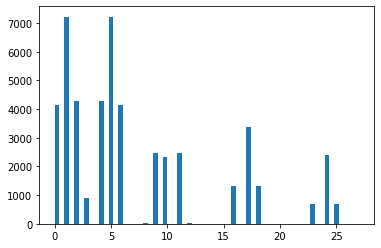

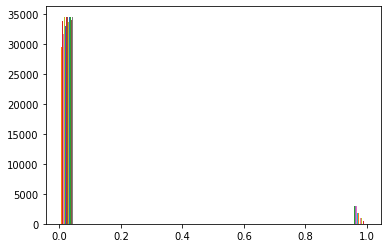

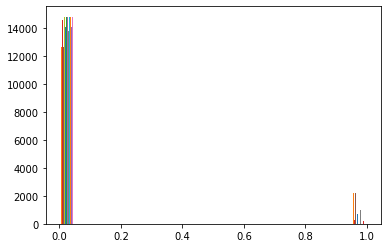

In [3]:
import matplotlib.pyplot as plt

print(classes_train[100], classes_validation[100])


plt.show()
n, bins, patches = plt.hist(x=array_classes, bins='auto')
plt.show()



#n, bins, patches = plt.hist(x=train_ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=classes_train, bins='auto')
plt.show()



plt.show()
n, bins, patches = plt.hist(x=classes_validation, bins='auto')
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

def lenet(input_shape):

    model = Sequential()
    #model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=28, activation = 'sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    '''
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))

    model.add(Dense(units=28, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    '''
    return model

In [8]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
print(images_train[0].shape)
# print(annotations_train[0])
#print(img_shape)
img_shape = (60, 160, 3)
print(img_shape)


timesteps = 1
batch_size = 50  # 16
nb_epoch = 100  # 223
model_name = 'lenet'
model = lenet(img_shape)
model_filename = timestr + '_lenet_model_100_RGB_extreme'


if type_image == 'cropped':
    model_file = '/content/drive/My Drive/' + model_filename + '.h5'


# Print layers
print(model)
model.build(img_shape)
print(model.summary())

import datetime
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, CSVLogger

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="accuracy", patience=40, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = "/content/drive/My Drive/" + model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
csv_logger = CSVLogger("/content/drive/My Drive/" + model_filename + '.csv', append=True)


# Train
model_history = model.fit(images_train, classes_train, epochs=nb_epoch, batch_size=batch_size, verbose=2, validation_data=(images_validation, classes_validation), callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)


# Evaluate the modelpil
score = model.evaluate(images_validation, classes_validation, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = batch_size
    f.attrs['nb_epoch'] = nb_epoch
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(array_annotations)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

20210316-140343
(60, 160, 3)
(60, 160, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 58, 158, 6)        168       
_________________________________________________________________
average_pooling2d (AveragePo (None, 29, 79, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 77, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 38, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7904)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               948600    
_________________________________________________________________
dense_3 (Den

KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit